In [1]:
#======== For Colab environment ========

# from google.colab import drive

# drive.mount('/content/gdrive')

# project_dir = '/content/gdrive/MyDrive/Colab Notebooks/UoA_MSDS/Course_13/Capstone2_Eye_for_the_blind'
# input_dir = f'/content'
# out_dir = f'{project_dir}/output'
# features_dir = f'{input_dir}/features'
# checkpoint_dir = f'{project_dir}/checkpoints'
# checkpoint_path = f'{checkpoint_dir}/train'
# checkpoint_finetune_path = f'{checkpoint_dir}/finetune'

In [2]:
#======== For Kaggle environment ========

project_dir = '/kaggle/working'
input_dir = '/kaggle/input'
out_dir = f'{project_dir}/output'
features_dir = f'{project_dir}/features'
checkpoint_dir = f'{project_dir}/checkpoints'
checkpoint_path = f'{checkpoint_dir}/train'
checkpoint_finetune_path = f'{checkpoint_dir}/finetune'

In [3]:
#======== For local environment ========

# project_dir = '.'
# input_dir = '.'
# out_dir = f'{project_dir}/output'
# features_dir = f'{project_dir}/features'
# checkpoint_dir = f'{project_dir}/checkpoints'
# checkpoint_path = f'{checkpoint_dir}/train'
# checkpoint_finetune_path = f'{checkpoint_dir}/finetune'

# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [4]:
try:
    # Check if running in fresh jupyter container (CodeSpace environment, for example)
    import pandas as pd
except ImportError:
    # Fresh jupyter environment, install additional libraries
    !pip install -q pandas matplotlib scikit-learn tensorflow keras-preprocessing wordcloud nltk gTTS

In [5]:
#Import all the required libraries

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

try:
    from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
except ImportError:
    from keras_preprocessing.text import Tokenizer, tokenizer_from_json

try:
    from nltk.translate.bleu_score import sentence_bleu
except ImportError:
    !pip install -q nltk
    from nltk.translate.bleu_score import sentence_bleu

try:
    import keras_tuner
except ImportError:
    !pip install -q keras-tuner
    import keras_tuner

from collections import Counter

from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Image as IPyImage
from IPython.display import Audio as IPYAudio
# Install wordcloud for TPU environment
try:
    from wordcloud import WordCloud
except ImportError:
    !pip install -q wordcloud
    from wordcloud import WordCloud

try:
    from gtts import gTTS
except ImportError:
    !pip install -q gTTS
    from gtts import gTTS

import os
import glob
import time
import re
import json

import warnings
warnings.filterwarnings('ignore')

# tf.debugging.disable_traceback_filtering()

2024-09-04 18:33:11.730075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 18:33:11.730180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 18:33:11.904462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [6]:
# Use TPU to speed up training
if tpus := tf.config.list_logical_devices('TPU'):
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)

    strategy = tf.distribute.TPUStrategy(resolver)

    display('Running on TPU')
    display(tpus)
elif gpus := tf.config.list_logical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
    display('Running on GPU')
    display(gpus)
else:
    strategy = tf.distribute.get_strategy()
    display('No GPU available')

'Running on GPU'

[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

In [7]:
# Check if input is already prepared
if not os.path.exists(f'{input_dir}/flickr8k'):
    # Check if zip file is already downloaded, if not, download using kaggle cli
    if not os.path.exists(f'{project_dir}/flickr8k.zip'):
        !pip install -q kaggle
        !kaggle datasets download -q -p "{project_dir}" adityajn105/flickr8k
    n_files = os.system(f'unzip -l "{project_dir}/flickr8k.zip" | tail -n 1 | xargs echo -n | cut -d' ' -f2')
    !unzip -n "{project_dir}/flickr8k.zip" -d "{input_dir}"/flickr8k | tqdm --desc extracted --unit files --unit_scale --total {n_files} > /dev/null

# Create directories if not exist
for d in (out_dir, features_dir, checkpoint_dir):
    if not os.path.exists(d):
        os.makedirs(d)

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [8]:
#Import the dataset and read the image into a seperate variable

images = f'{input_dir}/flickr8k/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


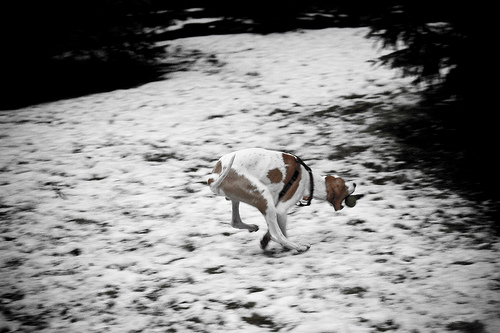

['A dog in a snowy area .',
 'A spotted dog catching a ball on a snowy field .',
 'A white and brown spotted dog runs along the snow to catch a ball .',
 'A white dog is running fast on a trail covered by snow .',
 'The brown and white dog is playing in the snow .']

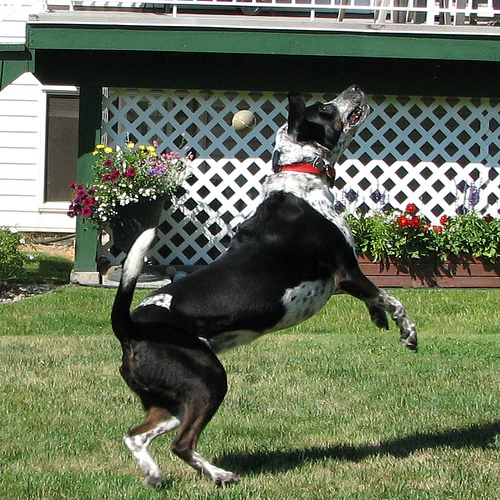

['A black and white dog is playing with a ball on a lawn .',
 'A black and white dog jumps up as a ball is thrown over his head .',
 'dog jumping looking up and small white ball in air passed by',
 'The black and white dog is attempting to catch a ball in the garden .',
 'The dog jumps up waiting to catch something being thrown .']

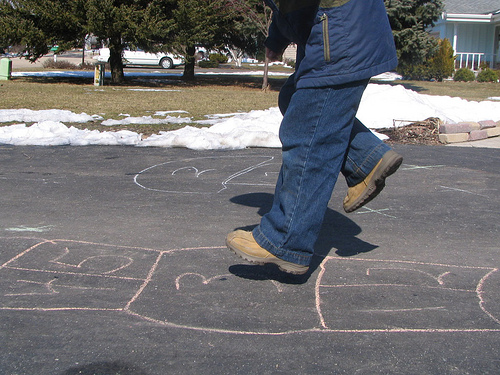

['A child in denim playing hopscotch .',
 'Closeup of a pair of feet in mid jump while playing hopscotch .',
 'Someone is playing hopscotch on a chalked out grid on the ground .',
 'The kid is playing hopscotch .',
 'The legs of a child playing hopscotch .']

In [9]:
#Visualise both the images & text present in the dataset
captions = pd.read_csv(f'{input_dir}/flickr8k/captions.txt')

# Display 3 images with corresponding captions
img_lst = [IPyImage(filename = img) for img in all_imgs[:3]]
caption_lst = [captions.loc[captions['image'] == img.split('/')[-1]]['caption'].to_list() for img in all_imgs[:3]]
display(*(item
          for zipped in zip(img_lst, caption_lst)
          for item in zipped))

In [10]:
#Import the dataset and read the text file into a seperate variable

text_file = f'{input_dir}/flickr8k/captions.txt'

def load_doc(filename):

    #your code here
    text = pd.read_csv(filename)
    return text

doc = load_doc(text_file)
print(doc[:300])

                         image  \
0    1000268201_693b08cb0e.jpg   
1    1000268201_693b08cb0e.jpg   
2    1000268201_693b08cb0e.jpg   
3    1000268201_693b08cb0e.jpg   
4    1000268201_693b08cb0e.jpg   
..                         ...   
295  1077546505_a4f6c4daa9.jpg   
296  1077546505_a4f6c4daa9.jpg   
297  1077546505_a4f6c4daa9.jpg   
298  1077546505_a4f6c4daa9.jpg   
299  1077546505_a4f6c4daa9.jpg   

                                               caption  
0    A child in a pink dress is climbing up a set o...  
1                A girl going into a wooden building .  
2     A little girl climbing into a wooden playhouse .  
3    A little girl climbing the stairs to her playh...  
4    A little girl in a pink dress going into a woo...  
..                                                 ...  
295  A boy in blue shorts slides down a slide into ...  
296  A boy in blue swimming trunks slides down a ye...  
297  A boy rides down a slide into a small backyard...  
298  A boy sliding do

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [11]:
#store all the image id here
all_img_id = [os.path.splitext(img)[0] for img in captions['image']]
#store all the image path here
all_img_vector = [next(p for p in all_imgs if id in p) for id in all_img_id]
#store all the captions here
annotations = captions['caption'].to_list()

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

df

ID  \
0      1000268201_693b08cb0e   
1      1000268201_693b08cb0e   
2      1000268201_693b08cb0e   
3      1000268201_693b08cb0e   
4      1000268201_693b08cb0e   
...                      ...   
40450   997722733_0cb5439472   
40451   997722733_0cb5439472   
40452   997722733_0cb5439472   
40453   997722733_0cb5439472   
40454   997722733_0cb5439472   

                                                    Path  \
0      /kaggle/input/flickr8k/Images/1000268201_693b0...   
1      /kaggle/input/flickr8k/Images/1000268201_693b0...   
2      /kaggle/input/flickr8k/Images/1000268201_693b0...   
3      /kaggle/input/flickr8k/Images/1000268201_693b0...   
4      /kaggle/input/flickr8k/Images/1000268201_693b0...   
...                                                  ...   
40450  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40451  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40452  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40453  /kaggle/input/flickr8k/Images/997722733_0cb543...   
40454  /kaggle/input/flickr8k/Images/997722733_0cb543...   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 3 columns]

In [12]:
#Create a list which contains all the captions
# annotations = annotations #write your code here

#add the <start> & <end> token to all those captions as well
annotations = [f'<start> {cap} <end>' for cap in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_vector #write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [13]:
#Create the vocabulary & the counter for the captions

vocabulary = [w.lower() for s in annotations for w in s.split() if w not in ('<start>', '<end>')] #write your code here

val_count = Counter(vocabulary)
val_count.most_common(10)

[('a', 62986),
 ('.', 36577),
 ('in', 18974),
 ('the', 18418),
 ('on', 10743),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7265)]

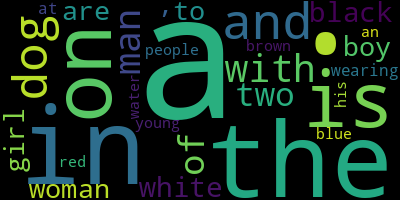

In [14]:
#Visualise the top 30 occuring words in the captions

#write your code here
WordCloud(max_words = 30).generate_from_frequencies(frequencies=val_count).to_image()

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [15]:
# create the tokenizer

#your code here
top_k = 5_000

tokenizer = Tokenizer(
    num_words = top_k,
    oov_token = '<unk>',
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
)

tokenizer.fit_on_texts(annotations)

In [16]:
# Create word-to-index and index-to-word mappings.

#your code here
tokenizer.index_word[0] = '<pad>' # Add padding token to index 0
tokenizer.word_index['<pad>'] = 0 # Set index 0 for padding token

word_to_index = tokenizer.word_index
index_to_word = tokenizer.index_word

annotation_sequences = tokenizer.texts_to_sequences(annotations)

display(pd.DataFrame.from_dict(word_to_index, orient = 'index'))
display(pd.DataFrame.from_dict(index_to_word, orient = 'index'))
print('\n', '='*30, '\n', sep='')
print(annotations[0])
print(annotation_sequences[0])

0
<unk>            1
a                2
<start>          3
<end>            4
in               5
...            ...
weight        8493
majestically  8494
scrolled      8495
patterns      8496
<pad>            0

[8497 rows x 1 columns]

0
1            <unk>
2                a
3          <start>
4            <end>
5               in
...            ...
8493        weight
8494  majestically
8495      scrolled
8496      patterns
0            <pad>

[8497 rows x 1 columns]



<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>
[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4]


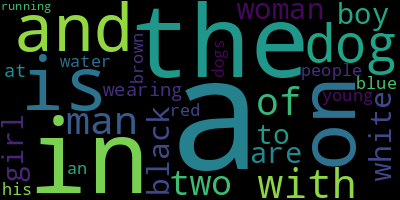

In [17]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
tokenized_word_count = Counter({
    k: v
    for k,v in tokenizer.word_counts.items()
    if k not in ('<start>', '<end>')
})

WordCloud(max_words = 30).generate_from_frequencies(tokenized_word_count).to_image()

In [18]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

cap_vector = keras.preprocessing.sequence.pad_sequences(
    annotation_sequences,
    padding = 'post'
) #your code here

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [19]:
#write your code here to create the dataset consisting of image paths
img_dataset = tf.data.Dataset.from_tensor_slices([*set(all_img_path)])

In [20]:
#write your code here for creating the function. This function should return images & their path

@tf.function
def load_image(image_path):
    #write your pre-processing steps here
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) #Resize to (299,299)
    img = tf.keras.applications.inception_v3.preprocess_input(img) #Normalize images
    return img, image_path

In [21]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
BATCH_SIZE = 64

img_dataset_preprocessed = img_dataset.map(
    load_image,
    num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=False,
)
# img_dataset_preprocessed = img_dataset_preprocessed.cache()
img_dataset_preprocessed = img_dataset_preprocessed.batch(BATCH_SIZE)
img_dataset_preprocessed = img_dataset_preprocessed.prefetch(tf.data.AUTOTUNE)

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [22]:
image_model = InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = Model(new_input, hidden_layer) #build the final model using both input & output layer

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
# Check if input is already prepared
if not os.path.exists(f'{input_dir}/flickr8k'):
    # If not, copy prepared features from input if running on Kaggle
    if os.path.exists(f'{input_dir}/vu-truong-capstone-2-eye-for-the-blind/features'):
        !cp -rf "{input_dir}/vu-truong-capstone-2-eye-for-the-blind/features"/* "{features_dir}/"

In [24]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
def save_features(batch_data):
    batch_imgs, batch_paths = batch_data

    def get_npy_path(img_path):
        img_filename = os.path.split(img_path.numpy().decode('utf-8'))[-1]
        full_save_path_without_ext = os.path.join(features_dir, img_filename)
        full_save_path = f'{full_save_path_without_ext}.npy'
        return full_save_path, full_save_path_without_ext

    # Skip batch if the images are already processed
    is_batch_processed = all(map(
        lambda path: os.path.exists(get_npy_path(path)[0]),
        batch_paths,
    ))
    if is_batch_processed:
        return

    batch_features = image_features_extract_model(batch_imgs)
    batch_features = tf.reshape(
        batch_features,
        (batch_features.shape[0], -1, batch_features.shape[3]),
    )

    # Save features corresponding to image path
    for features, path in zip(batch_features, batch_paths):
        path = get_npy_path(path)[1]
        np.save(path, features.numpy())

if not len(os.listdir(features_dir)):
    # Apply feature extraction
    prog_bar = keras.utils.Progbar(len(img_dataset_preprocessed))

    for i, batch_data in enumerate(img_dataset_preprocessed):
        prog_bar.update(i + 1)
        save_features(batch_data)

127/127 ━━━━━━━━━━━━━━━━━━━━ 62s 487ms/step


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature.

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [25]:
#write your code here
path_train, path_test, cap_train, cap_test = train_test_split(
    all_img_path,
    cap_vector,
    test_size=0.2,
    random_state=42,
)

In [26]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [27]:
# Create a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

@tf.numpy_function(Tout=(tf.float32, tf.int32))
def map_func(img_path, caption):
    img_file_name = os.path.split(img_path.decode('utf-8'))[-1]
    img_tensor = np.load(f'{features_dir}/{img_file_name}.npy') # write your code here to extract the features from the dictionary stored earlier
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [28]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(img_paths, captions):
    # your code goes here to create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, captions))
    dataset = dataset.map(
        map_func,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False,
    )
    # dataset = dataset.cache()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [29]:
with strategy.scope():
    train_dataset = gen_dataset(path_train,cap_train)
    test_dataset = gen_dataset(path_test,cap_test)

In [30]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [31]:
embedding_dim = 256
units = 512
vocab_size = top_k + 1 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [32]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = keras.layers.Dense(embed_dim, activation = 'relu') #build your Dense layer with relu activation

    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)

        return features

### Attention model

In [33]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = keras.layers.Dense(units) #build your Dense layer
        self.W2 = keras.layers.Dense(units) #build your Dense layer
        self.V = keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, axis = 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = self.V(
            tf.nn.tanh(
                self.W1(features) + self.W2(hidden_with_time_axis)
            )
        ) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.nn.softmax(score, axis = 1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reduce the shape to (batch_size, embedding_dim)


        return context_vector, attention_weights

### Decoder

In [34]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.attention = Attention_model(units) #iniitalise your Attention model with units
        self.embed = keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
#         self.gru = keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        # Build RNN from GRU cell instead of GRU layers since this issue: https://github.com/keras-team/keras/issues/19754
        self.gru = keras.layers.RNN(
            keras.layers.GRUCell(units, recurrent_initializer='glorot_uniform'),
            return_sequences=True,
            return_state=True,
        )
        self.d1 = keras.layers.Dense(units) #build your Dense layer
        self.d2 = keras.layers.Dense(vocab_size) #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output, state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [35]:
encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, units, vocab_size)

features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predictions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predictions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [36]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate = 0.0005,
    momentum = 0.001,
)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True,
    reduction = 'none',
)

In [37]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # Mask padding token
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # Loss will be 0 if padding token is present in real

    return tf.reduce_mean(loss_)

In [38]:
# Copy previous checkpoint from input if running on Kaggle
if os.path.exists(f'{input_dir}/vu-truong-capstone-2-eye-for-the-blind/checkpoints'):
    !cp -rf "{input_dir}/vu-truong-capstone-2-eye-for-the-blind/checkpoints" "{checkpoint_dir}"

In [39]:
EPOCHS = 15
loss_plot = pd.DataFrame({'loss': [], 'test_loss': []})

In [40]:
ckpt = tf.train.Checkpoint(encoder = encoder,
                           decoder = decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [41]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    print(f'============= Restoring from checkpoint {ckpt_manager.latest_checkpoint} =============')
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)
    loss_plot = pd.read_csv(f'{checkpoint_path}/loss.csv')

loss_plot

Empty DataFrame
Columns: [loss, test_loss]
Index: []

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [42]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Predict using decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions) # loss of a batch at i-th token

            # Teacher forcing, use token from target instead of prediction
            dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = loss / int(target.shape[1]) # Average loss over max length, include padding

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [43]:
@tf.function
def test_step(img_tensor, target):
    loss = 0

    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        # Predict using decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += loss_function(target[:, i], predictions) # loss of a batch at i-th token

        predicted_token_id =  tf.argmax(predictions,1) # Batch of predicted tokens
        dec_input = tf.expand_dims(predicted_token_id, 1)

    avg_loss = loss / int(target.shape[1]) # Average loss over max length, include padding

    return loss, avg_loss

In [44]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for batch, (img_tensor, target) in enumerate(test_dataset):
        _, batch_loss_avg = test_step(img_tensor, target)
        total_loss += batch_loss_avg

    avg_test_loss = total_loss / len(test_dataset)

    return avg_test_loss

In [45]:
def train_loop(train, test, start_epoch, end_epoch):
    best_test_loss = 100

    if start_epoch > 0:
        # Calculate current test loss before continue training from start_epoch
        best_test_loss = loss_plot.test_loss.values[-1]

    progbar = keras.utils.Progbar(
        target = (end_epoch - start_epoch) * len(train),
        stateful_metrics = [
            'EPOCH',
            'batch',
            'batch_loss',
        ],
    )

    for epoch in range(start_epoch, end_epoch):
        progbar.update((epoch - start_epoch) * len(train), values = [('EPOCH', epoch + 1)])
        total_loss = 0
        start = time.time()

        for batch, (img_tensor, target) in enumerate(train):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss
            progbar.update(
                (epoch - start_epoch) * len(train) + batch,
                values = [
                    ('EPOCH', epoch + 1),
                    ('batch', batch + 1),
                    ('batch_loss', batch_loss)
                ],
            )

        avg_train_loss = total_loss / len(train)
        test_loss = test_loss_cal(test)

        loss_plot.loc[epoch] = [avg_train_loss.numpy(), test_loss.numpy()]

        tf.print('\nFor epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
        tf.print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

        if test_loss < best_test_loss:
            tf.print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
            best_test_loss = test_loss
            ckpt_manager.save()
            loss_plot.to_csv(f'{checkpoint_path}/loss.csv', index = False)

train_loop(train_dataset, test_dataset, start_epoch, min(5, EPOCHS)) # Quick train on small number of epochs

 505/2530 ━━━━━━━━━━━━━━━━━━━━ 8:04 239ms/step - EPOCH: 1.0000 - batch: 506.0000 - batch_loss: 39.4818
For epoch: 1, the train loss is 1.324, & test loss is 1.900
Time taken for 1 epoch 195.74029278755188 sec

Test loss has been reduced from 100.000 to 1.900
1011/2530 ━━━━━━━━━━━━━━━━━━━━ 6:04 240ms/step - EPOCH: 2.0000 - batch: 506.0000 - batch_loss: 36.0834
For epoch: 2, the train loss is 1.087, & test loss is 1.891
Time taken for 1 epoch 102.92081356048584 sec

Test loss has been reduced from 1.900 to 1.891
1517/2530 ━━━━━━━━━━━━━━━━━━━━ 3:50 228ms/step - EPOCH: 3.0000 - batch: 506.0000 - batch_loss: 34.1923
For epoch: 3, the train loss is 1.014, & test loss is 1.850
Time taken for 1 epoch 102.98448872566223 sec

Test loss has been reduced from 1.891 to 1.850
2023/2530 ━━━━━━━━━━━━━━━━━━━━ 1:52 222ms/step - EPOCH: 4.0000 - batch: 506.0000 - batch_loss: 32.4702
For epoch: 4, the train loss is 0.967, & test loss is 1.874
Time taken for 1 epoch 103.08134174346924 sec

2529/2530 ━━━━━━━

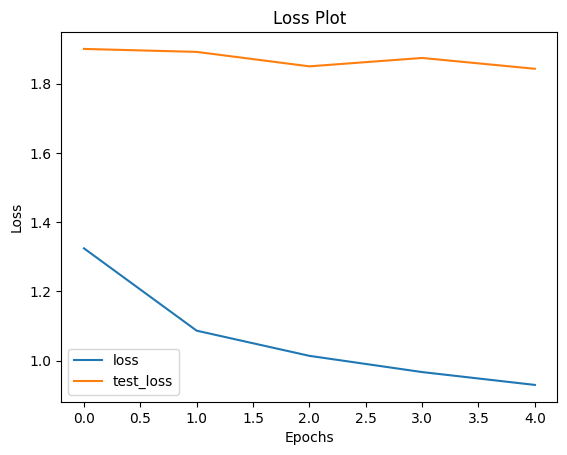

In [46]:
ax = loss_plot.plot()
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc = 'best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [47]:
# Save base models of encoder and decoder
encoder.save(f'{out_dir}/encoder.keras')
decoder.save(f'{out_dir}/decoder.keras')

#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

In [48]:
max_length = cap_vector.shape[1]
attention_features_shape = attention_weights.shape[1]

### Greedy Search

In [49]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    # Expand dims to match batch_size=1
    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # As batch_size=1, get single value for predicted_id
        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        
        # Return early on <end> token
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions
        
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        dec_input = tf.expand_dims([predicted_id], 0)
    return result, attention_plot, predictions


### Beam Search(optional)

In [50]:
def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search

    # Expand dims to match batch_size=1
    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    result = [{
        'dec_input': tf.expand_dims([tokenizer.word_index['<start>']], 0),
        'hidden': decoder.init_state(batch_size = 1),
        'attention_weights_lst': [np.zeros((attention_features_shape,))], # List of attention weights, use later to plot
        'prob': .0,
        'sequence': [],
    }]

    # Loop over max sequence length
    for i in range(max_length):
        # Check if all results reach <end> token to break early
        if all(
            map(
                lambda seq: len(seq) and seq[-1] == '<end>',
                map(
                    lambda res: res['sequence'],
                    result,
                )
            )
        ):
            break

        tmp_result = []
        # Loop over previous beam results
        for item in result:
            dec_input, hidden, attention_weights_lst, prob, sequence = item.values() # Get values from dict
            # If sequence is completed, skip it
            if len(sequence) and sequence[-1] == '<end>':
                continue

            predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder
            attention_weights = tf.reshape(attention_weights, (-1, )).numpy() # Current attention weights
            # Get predictions for current beam result
            beam_preds = np.argsort(predictions[0])[-beam_index:]

            # Loop over current predictions
            for pred_id in beam_preds:
                tmp_dec_input = tf.expand_dims([pred_id], 0)  # Current dec_input
                tmp_sequence = sequence[:] # Copy current result
                tmp_sequence.append(tokenizer.index_word[pred_id]) # Append token
                tmp_prob = prob + np.log(predictions[0][pred_id]) # Get new prob by adding prob of the prediction
                # Append to tmp_result
                tmp_result.append({
                    'dec_input': tmp_dec_input,
                    'hidden': tf.identity(hidden), # Copy hidden state
                    'attention_weights_lst': [
                        *attention_weights_lst,
                        tf.identity(attention_weights), # Copy attention weights
                    ],
                    'prob': tmp_prob,
                    'sequence': tmp_sequence,
                })

        # Sort the tmp_result by probabilities
        tmp_result = sorted(tmp_result, key = lambda res: res['prob'], reverse=False) # Sort ascending
        # Keep the best results
        result = tmp_result[-beam_index:]

    # After beam search completes, choose the best one
    final = result[-1]
    _, _, attention_plot, _, final_caption = final.values() # Get values from dict
    attention_plot = np.stack(attention_plot) # Stack the list with weights

    return final_caption, attention_plot

In [51]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    columns = int(np.ceil(np.sqrt(len_cap)))
    rows = int(np.ceil(len_cap / columns))
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(rows, columns, cap + 1)
        ax.set_title(caption[cap], fontsize = 15)

        img = ax.imshow(temp_img)

        ax.imshow(weights_img, cmap = 'gist_heat', alpha = 0.6, extent = img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace = 0.2, wspace = 0.2)
    plt.show()

In [52]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BLEU score: 47.58733096412522
Real Caption: people dressed in costumes are on skis
Prediction Caption: a group of people are walking down a group of a group of people are walking down a group of a group of people are walking down a group of a group of people are walking down a group


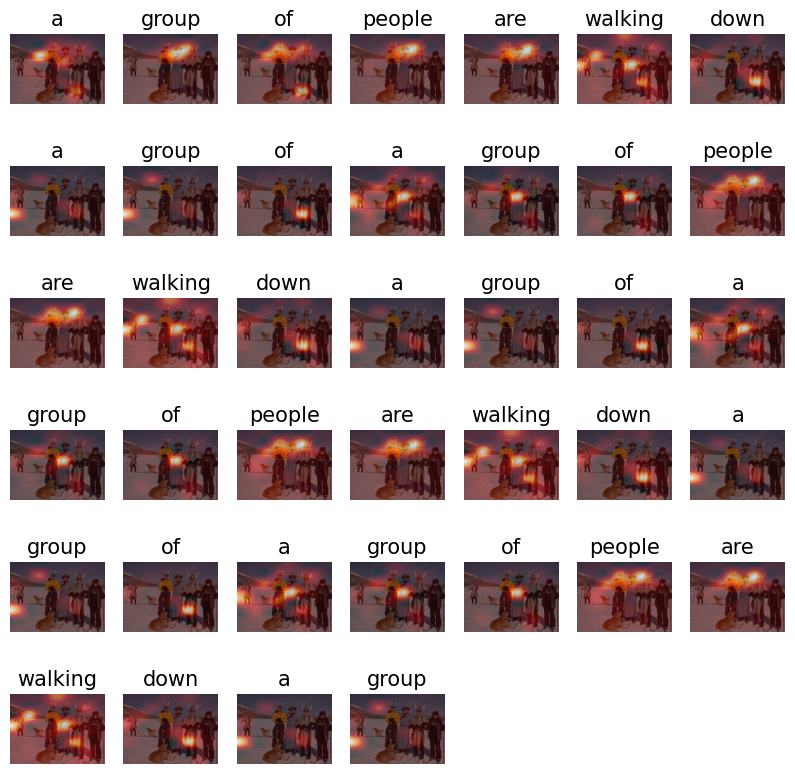

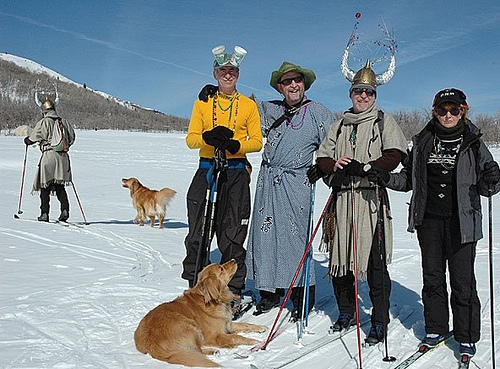

In [53]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)


real_caption = filt_text(real_caption)


pred_caption = ' '.join(result)

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate) # BLEU score 4-grams
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

a group of a group of a group of a group of a group of a group of a group of a group of a group of a group of a group of a group of a group


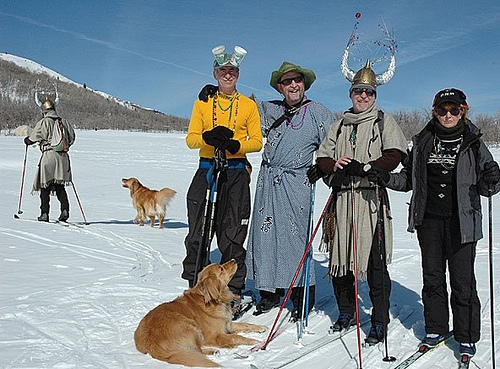

In [54]:
captions, _ = beam_evaluate(test_image)
captions = ' '.join(captions).rsplit(' ', 1)[0]
print(captions)
Image.open(test_image)

In [55]:
# Generate audio for the caption
gTTS(text = captions, lang = 'en', slow=False).save('captions.mp3')
IPYAudio("captions.mp3", autoplay=False)

## Hyperparameters tuning

The hyperparameters hyphothesized to have impact on the model are:
- **Optimizer**: experiment with Adam and RMSProp as these are the ones that converge quickly with little overshoot
- **Learning rate**: as with low amount of resources for tuning, I will search with in a range from 0.001 to 0.1, log scale, pick 5 values for random search
- **EPOCHS**: We can get better result by training with more EPOCHS, but at the expense of training time, so I will keep the default EPOCHS value.
- **Batch size**: is likely to only affect the memory during training and not much effect on loss so I don't intend to tune it, just choose 64 as a balance for memory on Kaggle environment
- **Embedding dims**: increasing may give better results but will need more EPOCHS as the network is getting bigger, just keep default of 256
- **Dropout**: is for controlling overfitting so it may have effect, but too resource-consuming and time-consuming to experiment. No dropout is used.
- **Batch norm**: is for speeding up the optimization, but as the train loss is gradually decreasing so batch norm is not used.


To tune chosen optimizers and learning rate, I use `keras_tuner` to randomly search in the search space with 5 trials on a smaller dataset (a fraction of the train dataset, for quick convergence), the best hyperparameters and model will be chosen to train on whole dataset and with more epochs.

In [56]:
## Custom model
@keras.utils.register_keras_serializable()
class CapGen(keras.Model):
    def __init__(self, tokenizer, embedding_dim, units, vocab_size, max_length, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tokenizer = tokenizer
        self.embedding_dim = embedding_dim
        self.units = units
        self.vocab_size = vocab_size
        self.max_length = max_length
        # Encoder components
        self.encoder = keras.layers.Dense(embedding_dim, activation = 'relu')
        # Attention components
        self.W1 = keras.layers.Dense(units) #build your Dense layer
        self.W2 = keras.layers.Dense(units) #build your Dense layer
        self.V = keras.layers.Dense(1) #build your final Dense layer with unit 1
        # Decoder components
        self.embed = keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length) #build your Embedding layer
#         self.gru = keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        # Build RNN from GRU cell instead of GRU layers since this issue: https://github.com/keras-team/keras/issues/19754
        self.gru = keras.layers.RNN(
            keras.layers.GRUCell(units, recurrent_initializer='glorot_uniform'),
            return_sequences=True,
            return_state=True,
        )
        self.d1 = keras.layers.Dense(units) #build your Dense layer
        self.d2 = keras.layers.Dense(vocab_size) #build your Dense layer
        
    def build(self, input_shape):
        # call using random input 
        self.call(keras.random.normal(input_shape))
        self.built = True

    def get_config(self):
        config = super().get_config()
        # Add any CapGen specific configurations here if needed
        # For example:
        # config['vocab_size'] = self.vocab_size
        config['tokenizer'] = self.tokenizer.to_json()
        config['embedding_dim'] = self.embedding_dim
        config['units'] = self.units
        config['vocab_size'] = self.vocab_size
        config['max_length'] = self.max_length
        return config

    @classmethod
    def from_config(cls, config):
        tokenizer = tokenizer_from_json(config['tokenizer'])
        del config['tokenizer']
        return cls(**config, tokenizer = tokenizer)

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

    @tf.function
    def encode(self, img_tensor):
        # Encode
        features = self.encoder(img_tensor) # extract the features from the image shape: (batch, 8*8, embed_dim)
        return features

    @tf.function
    def attention(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, axis = 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = self.V(
            tf.nn.tanh(
                self.W1(features) + self.W2(hidden_with_time_axis)
            )
        ) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = tf.nn.softmax(score, axis = 1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reduce the shape to (batch_size, embedding_dim)

        return context_vector, attention_weights

    @tf.function
    def decode(self, x, features, hidden):
        # Decode
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        gru_input = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output, state = self.gru(gru_input) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output, state, attention_weights

    @property
    def metric_dict(self):
        scalar_metrics = {m.name: m.result() for m in self.metrics if not isinstance(m.result(), dict)}
        compiled_metrics = {k: v
                                for nested in self.metrics
                                if isinstance(nested.result(), dict)
                                for k, v in nested.result().items()
                            }
        return scalar_metrics | compiled_metrics

    @tf.function
    def train_step_fn(self, target, dec_input, img_tensor, hidden):
        preds = dec_input
        loss = 0
        features = self.encode(img_tensor)

        for i in range(1, target.shape[1]):
            # Predict using decoder
            predictions, hidden, _ = self.decode(dec_input, features, hidden)
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss += self.loss(target[:, i], predictions) # loss of a batch at i-th token

            # Save predictions to calculate metrics
            predicted_token_id =  tf.argmax(predictions, 1, output_type = tf.int32) # Batch of predicted tokens
            predicted_token_id = tf.cast(tf.expand_dims(predicted_token_id, 1), tf.int32)
            preds = tf.concat([preds, predicted_token_id], axis = 1)

            # Teacher forcing, use token from target instead of prediction
            dec_input = tf.cast(tf.expand_dims(target[:, i], 1), tf.int32)
        return preds, loss

    def train_step(self, data):
        img_tensor, target = data
        batch_size = img_tensor.shape[0]
        hidden = self.init_state(batch_size=tf.cast(tf.shape(img_tensor)[0], tf.int32))
        dec_input = tf.expand_dims([self.tokenizer.word_index['<start>']] * img_tensor.shape[0], 1)


        with tf.GradientTape() as tape:
            preds, loss = self.train_step_fn(target, dec_input, img_tensor, hidden)

            self._loss_tracker.update_state(loss)
            if self.optimizer is not None:
                loss = self.optimizer.scale_loss(loss)

        # Compute gradients
        if self.trainable_weights:
            trainable_weights = self.trainable_weights
            gradients = tape.gradient(loss, trainable_weights)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_weights))
        else:
            warnings.warn("The model does not have any trainable weights.")

        # Update loss
        self._loss_tracker.update_state(
            loss, sample_weight=tf.shape(keras.tree.flatten(img_tensor)[0])[0]
        )
        # Update the metrics.
        self.compiled_metrics.update_state(target, preds)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return self.metric_dict

    @tf.function
    def test_step_fn(self, target, dec_input, img_tensor, hidden):
        preds = dec_input
        loss = 0
        features = self.encode(img_tensor)

        for i in range(1, target.shape[1]):
            # Predict using decoder
            predictions, hidden, _ = self.decode(dec_input, features, hidden)
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss += self.loss(target[:, i], predictions) # loss of a batch at i-th token
            predicted_token_id =  tf.argmax(predictions, 1, output_type = tf.int32) # Batch of predicted tokens
            dec_input = tf.cast(tf.expand_dims(predicted_token_id, 1), tf.int32)
            # Save predictions to calculate metrics
            preds = tf.concat([preds, dec_input], axis = 1)

        return preds, loss

    def test_step(self, data):
        img_tensor, target = data
        batch_size = img_tensor.shape[0]
        hidden = self.init_state(batch_size=batch_size)
        dec_input = tf.expand_dims([self.tokenizer.word_index['<start>']] * batch_size, 1)

        preds, loss = self.test_step_fn(target, dec_input, img_tensor, hidden)

        # Update loss
        self._loss_tracker.update_state(
            loss, sample_weight=tf.shape(keras.tree.flatten(img_tensor)[0])[0]
        )
        # Update the metrics.
        self.compiled_metrics.update_state(target, preds)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return self.metric_dict

    def fit(
            self,
            train_dataset,
            epochs = 1,
            initial_epoch = 0,
            validation_data = None,
            callbacks = None,
            verbose = 'auto',
            *args,
            **kwargs,
        ):
        '''
        Override fit method as dataset will force the whole loop into graph mode.
        We don't want Symbolic Tensor.
        '''
        step_per_epoch = len(train_dataset)
        if validation_data:
            step_per_epoch += len(validation_data)

        # Container that configures and calls callbacks.
        if not isinstance(callbacks, keras.callbacks.CallbackList):
            callbacks = keras.callbacks.CallbackList(
                callbacks,
                add_history = True,
                add_progbar = verbose != 0,
                verbose = verbose,
                epochs = epochs,
                steps = len(train_dataset),
                model = self,
            )

        callbacks.on_train_begin()
        logs = {}
        initial_epoch = self._initial_epoch or initial_epoch
        # Run custom loop outside graph mode
        for epoch in range(initial_epoch, epochs):
            self.reset_metrics()
            callbacks.on_epoch_begin(epoch)
            for batch, data in enumerate(train_dataset):
                callbacks.on_train_batch_begin(batch)
                logs = self.train_step(data)
                logs = self._pythonify_logs(logs)
                callbacks.on_train_batch_end(batch, logs)
                
            # Override with model metrics instead of last step logs if needed.
            epoch_logs = dict(self._get_metrics_result_or_logs(logs))

            # Run a validation loop at the end of each epoch.
            # Run validation.
            if validation_data:
                val_logs = self.evaluate(
                    validation_data,
                    #steps=len(validation_data),
                    callbacks=callbacks,
                    return_dict=True,
                    #_use_cached_eval_dataset=True,
                )
                val_logs = {
                    "val_" + name: val for name, val in val_logs.items()
                }
                epoch_logs.update(val_logs)

            callbacks.on_epoch_end(epoch, epoch_logs)
            training_logs = epoch_logs

        if (
            isinstance(self.optimizer, keras.optimizers.Optimizer)
            and epochs > 0
        ):
            self.optimizer.finalize_variable_values(self.trainable_weights)
        callbacks.on_train_end(training_logs)

        return self.history


    def evaluate(
        self,
        test_dataset,
        verbose = 'auto',
        steps = None,
        callbacks = None,
        return_dict = True,
        *args,
        **kwargs,
    ):
        '''
        Override evaluate method as dataset will force the whole loop into graph mode.
        We don't want Symbolic Tensor.
        '''
        if not isinstance(callbacks, keras.callbacks.CallbackList):
            callbacks = keras.callbacks.CallbackList(
                callbacks,
                add_history = True,
                add_progbar = verbose != 0,
                epochs = 1,
                verbose = verbose,
                steps = len(test_dataset),
                model = self,
            )

        callbacks.on_test_begin()
        logs = {}
        self.reset_metrics()
        # Run custom loop outside graph mode
        for batch, data in enumerate(test_dataset):
            callbacks.on_test_batch_begin(batch)
            logs = self.test_step(data)
            logs = self._pythonify_logs(logs)
            callbacks.on_test_batch_end(batch, logs)

        logs = self._get_metrics_result_or_logs(logs)
        callbacks.on_test_end(logs)

        if return_dict:
            return logs
        return self._flatten_metrics_in_order(logs)

    def call(self, img_tensor):
        batch_size = img_tensor.shape[0]
        attention_shape = img_tensor.shape[1]
        hidden = self.init_state(batch_size=batch_size)
        dec_input = tf.expand_dims([self.tokenizer.word_index['<start>']] * batch_size, 1)

        @tf.function
        def step_fn(dec_input, img_tensor, hidden):
            features = self.encode(img_tensor)
            preds = dec_input
            attention_plot = tf.zeros((batch_size, 1, attention_shape))

            for i in range(self.max_length):
                # Predict using decoder
                predictions, hidden, attention_weights = self.decode(dec_input, features, hidden)
                predicted_token_id =  tf.argmax(predictions, 1, output_type = tf.int32) # Batch of predicted tokens
                predicted_token_id = tf.cast(tf.expand_dims(predicted_token_id, 1), tf.int32)
                dec_input = predicted_token_id
                # Save predictions to calculate metrics
                preds = tf.concat([preds, predicted_token_id], axis = 1)
                # Save attention weights to plot later
                attention_plot = tf.concat([attention_plot, tf.reshape(attention_weights, (batch_size, 1, -1))], axis = 1)

            return preds, attention_plot

        preds, attention_plot = step_fn(dec_input, img_tensor, hidden)

        return preds, attention_plot

In [57]:
@tf.function
def loss_fn(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits = True,
        reduction = 'none',
    )
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # Mask padding token
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # Loss will be 0 if padding token is present in real

    return tf.reduce_mean(loss_)

In [58]:
# Metric
@tf.function
def masked_acc(labels, preds):
    mask = tf.cast(labels!=0, tf.float32)
    preds = tf.cast(preds, tf.int32) # Cast preds to float32 to match labels type
    labels = tf.cast(labels, tf.int32)
    matching = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(matching * mask) / tf.reduce_sum(mask)
    return acc

In [59]:
@tf.numpy_function(Tout=(tf.float32,))
def bleu_metric(batch_reference_tokens, batch_pred_tokens):
    scores = []
    for reference_tokens, pred_tokens in zip(batch_reference_tokens, batch_pred_tokens):
        reference = [tokenizer.index_word[x] for x in reference_tokens if x not in [0]]
        preds = [tokenizer.index_word[x] for x in pred_tokens if x not in [0]]
        scores.append(sentence_bleu([reference], preds) * 100) # BLEU score 4-grams

    return np.mean(scores)

In [60]:
def eval_model(model):
    batch_id, idx_id = np.random.randint(0, len(test_dataset)), np.random.randint(0, BATCH_SIZE)
    test_img_batch, test_cap_batch = next(iter(test_dataset.skip(batch_id)))
    test_img, test_cap = test_img_batch[idx_id].numpy(), test_cap_batch[idx_id].numpy()
    test_img = tf.expand_dims(test_img, 0)

    preds, attention = model(test_img)

    score = bleu_metric(tf.expand_dims(test_cap, 0), preds)

    real_sequence = [tokenizer.index_word[tok]
                    for tok in test_cap.flatten()
                    if tok not in [
                        0,
                        *(tokenizer.word_index[x] for x in ('<start>', '<unk>', '<end>'))
                    ]]
    real_caption = ' '.join(real_sequence)

    pred_sequence = [tokenizer.index_word[tok]
                    for tok in preds.numpy().flatten()
                    if tok not in [
                        0,
                        *(tokenizer.word_index[x] for x in ('<start>', '<unk>', '<end>'))
                    ]]
    pred_caption = ' '.join(pred_sequence)
    print(f"BLEU score: {score}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(pred_sequence, attention.numpy()[0], path_test[batch_id * BATCH_SIZE + idx_id])

    display(Image.open(path_test[batch_id * BATCH_SIZE + idx_id]))
    
    return pred_caption

In [61]:
capgen = CapGen(tokenizer, embedding_dim, units, vocab_size, max_length)
capgen.compile(optimizer = tf.keras.optimizers.RMSprop(
    learning_rate = 0.0005,
), loss = loss_fn, metrics = [masked_acc, bleu_metric])

capgen.build(input_shape=sample_img_batch.shape)
capgen.summary()

Model: "cap_gen"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (64, 64, 256)          │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (64, 64, 512)          │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (64, 1, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (64, 64, 1)            │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (64, 1, 256)           │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (RNN)                     │ ((64, 1, 512), (64,    │     1,575,936 │
│                                 │ 512))                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (64, 1, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (64, 5001)             │     2,565,513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,603,658 (25.19 MB)

 Trainable params: 6,603,658 (25.19 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
display(
    # Quick train on 1 epoch and evaluate on 50 test batches
    capgen.fit(
        train_dataset,
        validation_data = test_dataset.take(50),
        epochs = 1,
    ).history
)

506/506 ━━━━━━━━━━━━━━━━━━━━ 230s 425ms/step - bleu_metric: 32.6629 - loss: 45.4623 - masked_acc: 0.2594 - val_bleu_metric: 28.3238 - val_loss: 42.6294 - val_masked_acc: 0.2201


{'bleu_metric': [31.71653938293457],
 'loss': [31.128517150878906],
 'masked_acc': [0.3095344305038452],
 'val_bleu_metric': [28.32378578186035],
 'val_loss': [42.62944793701172],
 'val_masked_acc': [0.22012750804424286]}

In [63]:
capgen.save(f'{out_dir}/dummy_model.keras')

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - bleu_metric: 27.5031 - loss: 41.3801 - masked_acc: 0.2218


{'bleu_metric': 27.71371078491211,
 'loss': 41.427040100097656,
 'masked_acc': 0.2256053388118744}

BLEU score: 23.793665482062618
Real Caption: a singer singing on with a guitar player in the background
Prediction Caption: a woman in a red shirt is sitting on a red shirt is sitting on a red shirt is sitting on a red shirt is sitting on a red shirt is sitting on a red shirt is sitting on


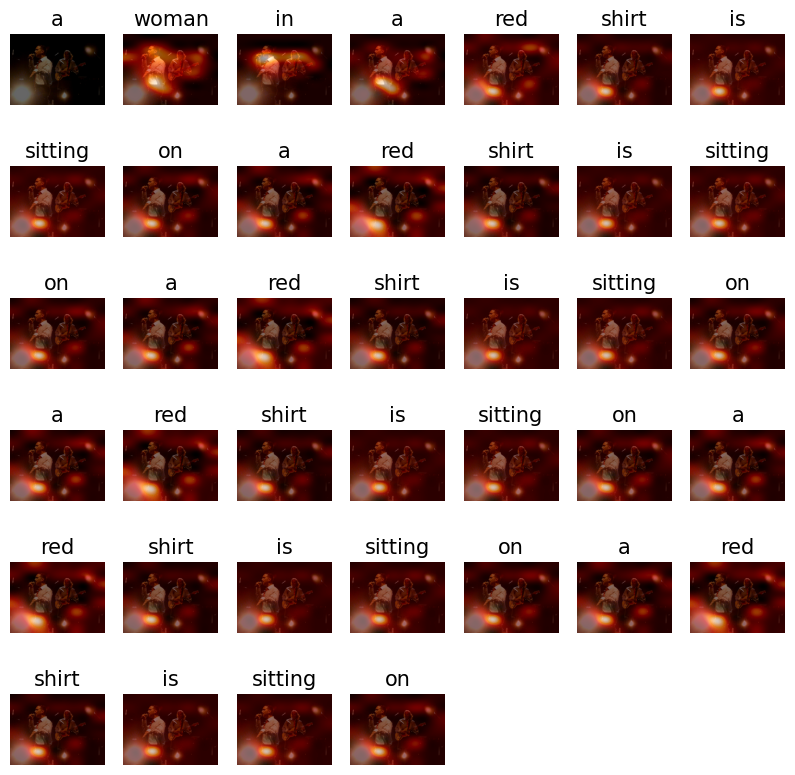

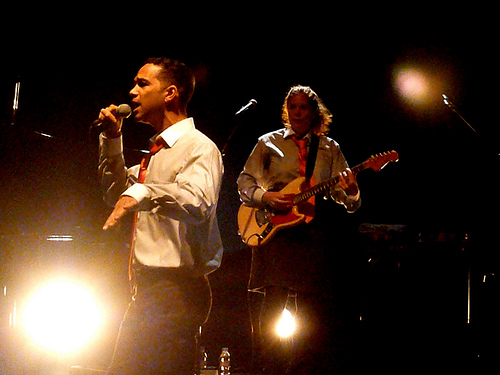

In [64]:
capgen = tf.keras.models.load_model(
    f'{out_dir}/dummy_model.keras',
    custom_objects = {
        'loss_fn': loss_fn,
        'masked_acc': masked_acc,
        'bleu_metric': bleu_metric,
    },
    compile = False,
)

capgen.compile(optimizer = tf.keras.optimizers.RMSprop(
    learning_rate = 0.0005,
), loss = loss_fn, metrics = [masked_acc, bleu_metric])

display(capgen.evaluate(test_dataset.take(5), return_dict = True))

pred_caption = eval_model(capgen)

In [65]:
class HyperCapGen(keras_tuner.HyperModel):
    def __init__(self, tokenizer, embedding_dim, units, vocab_size, max_length):
        self.tokenizer = tokenizer
        self.embedding_dim = embedding_dim
        self.units = units
        self.vocab_size = vocab_size
        self.max_length = max_length

    def build(self, hp):
        model = CapGen(self.tokenizer, self.embedding_dim, self.units, self.vocab_size, self.max_length)
        learning_rate = hp.Float("learning_rate", min_value = 0.001, max_value = 0.1, step = 5, sampling = 'log')
        optimizer = hp.Choice("optimizer", ['RMSprop', 'Adam'])
        if optimizer == 'RMSprop':
            optimizer_inst = keras.optimizers.RMSprop(learning_rate = learning_rate)
        #elif optimizer == 'Adam':
        else:
            optimizer_inst = keras.optimizers.Adam(learning_rate = learning_rate)

        model.compile(
            optimizer = optimizer_inst,
            loss = loss_fn,
            metrics = [masked_acc, bleu_metric],
            # steps_per_execution = 10, # Speed up tuning by executing more batches per step
        )
        return model

    def fit(self, hp, model, *args, **kwargs):

        return model.fit(*args, **kwargs)

In [66]:
tuner = keras_tuner.RandomSearch(
    hypermodel=HyperCapGen(tokenizer, embedding_dim, units, vocab_size, max_length),
    objective=keras_tuner.Objective("masked_acc", "max"), # Use masked_acc as objective
    #objective=keras_tuner.Objective("bleu_metric", "max"),  # Use bleu_metric as objective
    max_trials=6,
    #executions_per_trial=2, # More models per trial to reduce results variance
    # overwrite=True,
    directory=f"{checkpoint_dir}/hyper_tune",
    project_name="tune_hypermodel_caption_generator",
)
tuner.search_space_summary()

Search space summary
Default search space size: 2
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 5, 'sampling': 'log'}
optimizer (Choice)
{'default': 'RMSprop', 'conditions': [], 'values': ['RMSprop', 'Adam'], 'ordered': False}


In [67]:
tuner.search(
    train_dataset,
    validation_data = test_dataset.take(50),
    epochs = 1,
) # Quick tune on 1 epoch

# Get best model
tuner.results_summary()

Trial 6 Complete [00h 04m 05s]
masked_acc: 0.21375860273838043

Best masked_acc So Far: 0.3393021523952484
Total elapsed time: 00h 23m 59s
Results summary
Results in /kaggle/working/checkpoints/hyper_tune/tune_hypermodel_caption_generator
Showing 10 best trials
Objective(name="masked_acc", direction="max")

Trial 3 summary
Hyperparameters:
learning_rate: 0.001
optimizer: Adam
Score: 0.3393021523952484

Trial 0 summary
Hyperparameters:
learning_rate: 0.001
optimizer: RMSprop
Score: 0.325248658657074

Trial 5 summary
Hyperparameters:
learning_rate: 0.005
optimizer: Adam
Score: 0.21375860273838043

Trial 4 summary
Hyperparameters:
learning_rate: 0.005
optimizer: RMSprop
Score: 0.16826896369457245

Trial 2 summary
Hyperparameters:
learning_rate: 0.025
optimizer: RMSprop
Score: 0.0902026817202568

Trial 1 summary
Hyperparameters:
learning_rate: 0.025
optimizer: Adam
Score: 0.08542952686548233


In [68]:
best_hp = tuner.get_best_hyperparameters()[0]
models = tuner.get_best_models(num_models = 1)
best_model = models[0]
best_model.build(input_shape = sample_img_batch.shape)
best_model.summary()

Model: "cap_gen"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (64, 64, 256)          │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 64, 512)          │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 1, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (64, 64, 1)            │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (64, 1, 256)           │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ ((64, 1, 512), (64,    │     1,575,936 │
│                                 │ 512))                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (64, 1, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (64, 5001)             │     2,565,513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,603,658 (25.19 MB)

 Trainable params: 6,603,658 (25.19 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
print('Best hyperparameters are:')
pd.DataFrame(best_hp.values, index = [0])

Best hyperparameters are:


learning_rate optimizer
0          0.001      Adam

In [70]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=f'{checkpoint_finetune_path}/checkpoint.best_model.' + '{epoch:02d}-{masked_acc:.2f}-{bleu_metric:.2f}.keras',
    monitor='masked_acc',
    mode='max',
    save_best_only=True,
)

training_backup_callback = keras.callbacks.BackupAndRestore(
    checkpoint_finetune_path, save_freq="epoch", delete_checkpoint=True,
)

In [71]:
# Check latest epoch
last_epoch = (
    json.load(f'{checkpoint_finetune_path}/training_metadata.json')['epoch']
    if os.path.exists(f'{checkpoint_finetune_path}/training_metadata.json')
    else 0
)
print(f'Last epoch trained from previous session: {last_epoch}')

Last epoch trained from previous session: 0


In [72]:
# Retrain model on entire datasets
train_history = best_model.fit(
    train_dataset.take(int(len(train_dataset) * 0.9)),
    validation_data = train_dataset.skip(int(len(train_dataset) * 0.9)),
    epochs = EPOCHS,
    callbacks=[model_checkpoint_callback, training_backup_callback],
)
display(train_history.history)
best_model.evaluate(test_dataset)

Epoch 1/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 224s 458ms/step - bleu_metric: 33.1174 - loss: 46.4226 - masked_acc: 0.2731 - val_bleu_metric: 28.2947 - val_loss: 43.5517 - val_masked_acc: 0.2234
Epoch 2/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 202s 444ms/step - bleu_metric: 28.8325 - loss: 25.6033 - masked_acc: 0.3983 - val_bleu_metric: 27.3517 - val_loss: 44.1683 - val_masked_acc: 0.2301
Epoch 3/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 202s 443ms/step - bleu_metric: 27.5619 - loss: 25.8853 - masked_acc: 0.4225 - val_bleu_metric: 27.3690 - val_loss: 44.4810 - val_masked_acc: 0.2344
Epoch 4/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 202s 444ms/step - bleu_metric: 26.5733 - loss: 27.0344 - masked_acc: 0.4410 - val_bleu_metric: 27.2973 - val_loss: 46.4556 - val_masked_acc: 0.2347
Epoch 5/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 201s 441ms/step - bleu_metric: 25.7155 - loss: 28.8849 - masked_acc: 0.4555 - val_bleu_metric: 27.0318 - val_loss: 50.1873 - val_masked_acc: 0.2337
Epoch 6/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 202s 443ms/step - bl

{'bleu_metric': [31.62444496154785,
  28.476581573486328,
  27.222139358520508,
  26.203893661499023,
  25.383520126342773,
  24.65129280090332,
  23.940067291259766,
  23.31039810180664,
  22.78863525390625,
  22.22063636779785,
  21.925931930541992,
  21.227535247802734,
  20.905643463134766,
  20.495445251464844,
  20.343660354614258],
 'loss': [30.490753173828125,
  25.820186614990234,
  26.4068660736084,
  27.818199157714844,
  29.844785690307617,
  32.262596130371094,
  34.65761184692383,
  36.76893615722656,
  38.407325744628906,
  40.450035095214844,
  41.414920806884766,
  42.289390563964844,
  43.445613861083984,
  44.2996711730957,
  45.030181884765625],
 'masked_acc': [0.33068206906318665,
  0.4054635167121887,
  0.4275009334087372,
  0.4445815086364746,
  0.4592471420764923,
  0.47212228178977966,
  0.48490452766418457,
  0.49719730019569397,
  0.507519006729126,
  0.5173413753509521,
  0.5265015959739685,
  0.5389100909233093,
  0.5485091209411621,
  0.5574096441268921,
 

127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - bleu_metric: 27.8529 - loss: 79.5238 - masked_acc: 0.2184


{'bleu_metric': 27.9932804107666,
 'loss': 80.09180450439453,
 'masked_acc': 0.2171630561351776}

In [73]:
best_model.save(f'{out_dir}/tuned_model.keras')

BLEU score: 7.349664483463557
Real Caption: there are two large dogs running about in a field
Prediction Caption: two large brown dog running in a field


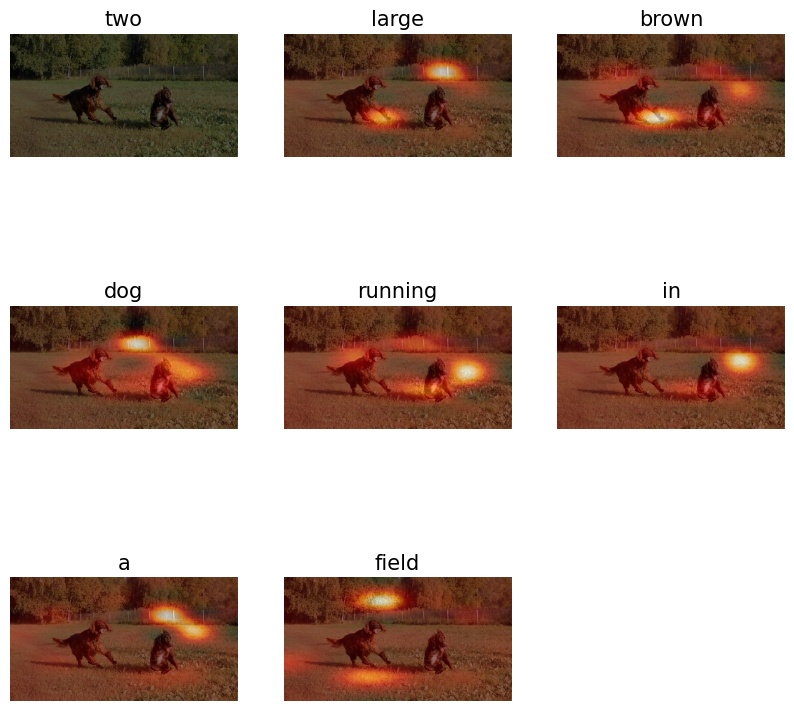

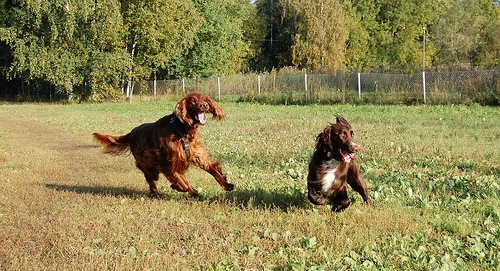

In [74]:
best_model = tf.keras.models.load_model(
    #f'{input_dir}/eye-for-the-blind/tensorflow2/default/1/tuned_model.keras',
    f'{out_dir}/tuned_model.keras',
    custom_objects = {
        'loss_fn': loss_fn,
        'masked_acc': masked_acc,
        'bleu_metric': bleu_metric,
    },
    compile = False,
)

best_model.compile(optimizer = tf.keras.optimizers.RMSprop(
    learning_rate = 0.0005,
), loss = loss_fn, metrics = [masked_acc, bleu_metric])

pred_caption = eval_model(best_model)

In [75]:
gTTS(text = pred_caption, lang = 'en', slow=False).save('pred_caption.mp3')
IPYAudio("pred_caption.mp3", autoplay=False)